In [1]:
import pandas as pd
import re
import struct
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

from scipy.signal import find_peaks

import matplotlib.colors as mcolors

current_dir = '/home/marian/CIGAR_ANALYSIS/CIGAR/notebooks'

# Build the absolute path to ../functions
functions_path = os.path.abspath(os.path.join(current_dir, '../functions'))

# Add it to sys.path
sys.path.append(functions_path)

import parse_data 
import cigar as cig

from tqdm import tqdm


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
colors = ['royalblue', 'crimson', 'black', 'green', 'darkorange', 'brown', 'coral', 'indigo', 'magenta', 'blue']


##  Data reading

In [3]:

start           = 1
nfiles          = 11


In [4]:
amp_factors = {'CH1':(313, 5.21e-8),
               'CH2':(254, 8.18e-8),
               'CH3':(254, 7.41e-8),
               'CH4':(326, 6.86e-8)
               }

amplified   = False

temperature = 9 # [deg]
pressure    = 5.5 # [bar]

pes         = True

nchannels   = 10

offline_trg = None
# offline_trg = 'AND'
# offline_trg = 'Majority3'

In [5]:
data_nosource = {'source':'no-source',
                 'run':'Run19',
                 'nchannels': nchannels,
                 'nevents_per_wvf': 500,
                 'samples_per_waveform': 752,
                 'event_header_bytes': 28,
                 'sample_binning': 8e-9,
                 'integration_window_min':1.8e-6,
                 'integration_window_max':3e-6,
                 'temperature':f'{temperature}deg',
                 'is_amplified':amplified,
                 'amp_factors':amp_factors,
                 'pes':pes
                 }

run_nosource_dir     = f"/home/marian/CIGAR_ANALYSIS/CIGAR/data/{data_nosource['run']}"


In [6]:
data_source = {'source':'Ba133',
               'run':'Run22',
               'nchannels': nchannels,
               'nevents_per_wvf': 500,
               'samples_per_waveform': 752,
               'event_header_bytes': 28,
               'sample_binning': 8e-9,
               'integration_window_min':1.8e-6,
               'integration_window_max':3e-6,
               'temperature':f'{temperature}deg',
               'is_amplified':amplified,
               'amp_factors':amp_factors,
               'pes':pes
               }

run_source_dir     = f"/home/marian/CIGAR_ANALYSIS/CIGAR/data/{data_source['run']}"


In [7]:
parse_data.checkWfs(run_nosource_dir, 
                    1, 5, 
                    data_nosource['nchannels'], 
                    data_nosource['samples_per_waveform'], 
                    data_nosource['event_header_bytes'], 
                    print_headers = False
                    )

/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run19
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)


In [8]:
parse_data.checkWfs(run_source_dir, 
                    1, 5, 
                    data_source['nchannels'], 
                    data_source['samples_per_waveform'], 
                    data_source['event_header_bytes'], 
                    print_headers = False
                    )

/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run22
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)


In [9]:

# Initialize an empty list to store DataFrames
dataframes_nosource = []

# Loop through each folder and read all CSV files
for i, file in enumerate(tqdm(os.listdir(run_nosource_dir)[start:nfiles],desc=f"Reading {data_nosource['source']} .bin files", unit="file")):
    if file.endswith(".bin"):
        file_path = os.path.join(run_nosource_dir, file)
        df = parse_data.parse_wf_from_binary(file_path, 
                                             channels = data_nosource['nchannels'], 
                                             n_events = data_nosource['nevents_per_wvf'],
                                             file_idx = i,
                                             event_header_bytes = data_nosource['event_header_bytes'],
                                             sample_binning = data_nosource['sample_binning']
                                             )   
        dataframes_nosource.append(df)

Reading no-source .bin files: 100%|██████████| 10/10 [00:25<00:00,  2.59s/file]


In [10]:

# Initialize an empty list to store DataFrames
dataframes_source = []

# Loop through each folder and read all CSV files
for i, file in enumerate(tqdm(os.listdir(run_source_dir)[-nfiles:-start],desc=f"Reading {data_source['source']} .bin files", unit="files")):
    if file.endswith(".bin"):
        file_path = os.path.join(run_source_dir, file)
        df = parse_data.parse_wf_from_binary(file_path, 
                                            channels = data_source['nchannels'], 
                                            n_events = data_source['nevents_per_wvf'],
                                            file_idx = i,
                                            event_header_bytes = data_source['event_header_bytes'],
                                            sample_binning = data_source['sample_binning']
                                            )  
        dataframes_source.append(df)

Reading Ba133 .bin files: 100%|██████████| 10/10 [00:21<00:00,  2.18s/files]


In [11]:
# Merge all DataFrames into one
merged_df_source    = pd.concat(dataframes_source, ignore_index=True)
merged_df_nosource  = pd.concat(dataframes_nosource, ignore_index=True)

In [12]:
merged_df_source.tail()

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,event,event_time,file_idx
3759995,0.000006,3.000907,2.636158,-368.640015,-533.874512,-409.954376,-531.537781,-351.508514,-558.209839,-407.899323,-533.113037,4999,379323641269,9
3759996,0.000006,2.755935,2.942688,-368.394226,-539.889709,-409.831482,-545.277039,-350.710907,-560.479248,-408.206909,-539.187866,4999,379323641269,9
3759997,0.000006,2.694692,2.881382,-367.718414,-550.630981,-409.462830,-563.432495,-349.974609,-559.375183,-408.637512,-547.717224,4999,379323641269,9
3759998,0.000006,2.572206,3.187912,-368.332794,-565.362000,-409.524261,-584.654724,-349.790558,-556.431091,-408.760529,-557.228333,4999,379323641269,9
3759999,0.000006,2.572206,3.126606,-368.640015,-582.548096,-409.708588,-605.386292,-349.422424,-555.879089,-408.883545,-568.028015,4999,379323641269,9


In [13]:
merged_df_nosource.tail()

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,event,event_time,file_idx
3759995,0.000006,2.265991,2.881382,-369.623047,-533.076599,-409.954376,-589.500305,-349.851898,-515.950012,-407.960846,-495.620880,4999,134237498655,9
3759996,0.000006,2.327234,2.881382,-370.237427,-506.745026,-410.384491,-593.487122,-349.606476,-518.648743,-408.883545,-505.684235,4999,134237498655,9
3759997,0.000006,2.510963,2.574852,-369.745911,-463.227325,-410.200134,-595.327209,-349.606476,-520.488831,-409.129608,-516.668030,4999,134237498655,9
3759998,0.000006,2.327234,2.574852,-369.868805,-408.047577,-410.507355,-597.535339,-350.035980,-520.550171,-409.314148,-525.381470,4999,134237498655,9
3759999,0.000006,2.082262,2.636158,-369.192963,-351.640289,-410.445923,-601.460815,-350.649536,-522.696899,-408.637512,-526.854126,4999,134237498655,9


##  Data selection

In [14]:
# Filter for a specific event (change index as needed)
event_list_source  = merged_df_source['event'].unique()
nevents_source     = len(event_list_source)
print(f'Events per file = {len(event_list_source)/len(os.listdir(run_source_dir)[-nfiles:-start])}. Total nevents = {len(event_list_source)}')

Events per file = 500.0. Total nevents = 5000


In [15]:
# Filter for a specific event (change index as needed)
event_list_nosource  = merged_df_nosource['event'].unique()
nevents_nosource     = len(event_list_nosource)
print(f'Events per file = {len(event_list_nosource)/len(os.listdir(run_nosource_dir)[start:nfiles])}. Total nevents = {len(event_list_nosource)}')


Events per file = 500.0. Total nevents = 5000


In [16]:
if nchannels == 5:
    Amp_channels    = ['CH2', 'CH3', 'CH4', 'CH5'] # Amp
    noAmp_channels  = [] # noAmp

elif nchannels == 9:
    Amp_channels    = ['CH3', 'CH5', 'CH7', 'CH9'] # Amp
    noAmp_channels  = ['CH2', 'CH4', 'CH6', 'CH8'] # noAmp

elif nchannels == 10:
    Amp_channels    = ['CH4', 'CH6', 'CH8', 'CH10'] # Amp
    noAmp_channels  = ['CH3', 'CH5', 'CH7', 'CH9'] # noAmp

if amplified:
    channels = Amp_channels
else:
    channels = noAmp_channels

all_channels    = noAmp_channels + Amp_channels


##  Data filtering

In [17]:
# function to count number of peaks above threshold for one waveform
def count_high_peaks(group, channels_to_check, threshold=1000):
    peak_count = 0
    for ch in channels_to_check:
        peaks, _ = find_peaks(group[f'{ch}'].values, height=threshold)
        peak_count += len(peaks)
    return peak_count

# group by event (or event_time if that's more appropriate)
peak_counts_source      = merged_df_source.groupby("event").apply(count_high_peaks, channels_to_check=Amp_channels, include_groups=False)
peak_counts_nosource    = merged_df_nosource.groupby("event").apply(count_high_peaks, channels_to_check=Amp_channels, include_groups=False)

# keep only events with <= 5 peaks above 2000
valid_events_source     = peak_counts_source[peak_counts_source <= 5].index
valid_events_nosource   = peak_counts_nosource[peak_counts_nosource <= 5].index

# filter the original dataframe
filtered_df_source = merged_df_source[merged_df_source["event"].isin(valid_events_source)]
filtered_df_nosource = merged_df_nosource[merged_df_nosource["event"].isin(valid_events_nosource)]

# update the number of valid events
event_list_source  = filtered_df_source['event'].unique()
nevents_source     = len(event_list_source)

event_list_nosource  = filtered_df_nosource['event'].unique()
nevents_nosource     = len(event_list_nosource)

##  Baseline correction

In [18]:
# DEFINITION OF THE BASELINE WINDOW WIDTH HERE
window_width = 50


In [19]:
corrected_df_nosource   = filtered_df_nosource.copy()
corrected_df_source     = filtered_df_source.copy()

for i, ch in enumerate(noAmp_channels):

    # NO SOURCE -------------------------------------------------------------------------
    voltage_nosource = filtered_df_nosource[f'{ch}'].values

    v_matrix_nosource                    = voltage_nosource.reshape(nevents_nosource, -1)
    # v_matrix_corrected_nosource, _, _    = cig.BaselineCorrection(v_matrix_nosource, window=window_width)
    v_matrix_corrected_nosource, _       = cig.FixBaselineCorrection(v_matrix_nosource, amplified = False, channel = i+1)

    corrected_df_nosource[f'{ch}'] = v_matrix_corrected_nosource.flatten()
    # SOURCE -------------------------------------------------------------------------
    voltage_source = filtered_df_source[f'{ch}'].values

    v_matrix_source                    = voltage_source.reshape(nevents_source, -1)
    # v_matrix_corrected_source, _, _    = cig.BaselineCorrection(v_matrix_source, window=window_width)
    v_matrix_corrected_source, _       = cig.FixBaselineCorrection(v_matrix_source, amplified = False, channel = i+1)

    corrected_df_source[f'{ch}'] = v_matrix_corrected_source.flatten()

for i, ch in enumerate(Amp_channels):

    # NO SOURCE -------------------------------------------------------------------------
    voltage_nosource = filtered_df_nosource[f'{ch}'].values

    v_matrix_nosource                    = voltage_nosource.reshape(nevents_nosource, -1)
    # v_matrix_corrected_nosource, _, _    = cig.BaselineCorrection(v_matrix_nosource, window=window_width)
    v_matrix_corrected_nosource, _       = cig.FixBaselineCorrection(v_matrix_nosource, amplified = True, channel = i+1)

    corrected_df_nosource[f'{ch}'] = v_matrix_corrected_nosource.flatten()
    # SOURCE -------------------------------------------------------------------------
    voltage_source = filtered_df_source[f'{ch}'].values

    v_matrix_source                    = voltage_source.reshape(nevents_source, -1)
    # v_matrix_corrected_source, _, _    = cig.BaselineCorrection(v_matrix_source, window=window_width)
    v_matrix_corrected_source, _       = cig.FixBaselineCorrection(v_matrix_source, amplified = True, channel = i+1)

    corrected_df_source[f'{ch}'] = v_matrix_corrected_source.flatten()

In [20]:
corrected_df_nosource

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,event,event_time,file_idx
752,8.000000e-09,2.572206,3.003994,-0.377289,42.310425,-0.937469,-6.981079,-0.220062,25.107056,-0.083862,364.860809,1,362531206068,0
753,1.600000e-08,2.388477,3.249218,-0.254395,46.361450,-1.244690,-6.919739,-0.220062,12.288025,0.100677,349.152145,1,362531206068,0
754,2.400000e-08,2.388477,2.390934,0.052795,69.071655,-1.183258,-5.508972,0.270813,-3.045715,-0.083862,324.423248,1,362531206068,0
755,3.200000e-08,2.143505,2.452240,-0.500153,115.842438,-1.060364,1.789978,0.086731,-13.533997,-0.022369,300.614807,1,362531206068,0
756,4.000000e-08,2.939664,2.758770,-0.070068,174.336639,-0.814575,11.726440,0.638947,-16.355408,0.223694,284.783417,1,362531206068,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3759243,5.984000e-06,2.265991,2.452240,-1.606079,22.976013,-2.043457,-17.653503,-0.710907,-3.536377,0.715820,332.707123,4998,133999612352,9
3759244,5.992000e-06,2.082262,2.513546,-1.667511,30.402893,-1.429016,11.665100,-0.158691,-9.424561,0.900360,315.218964,4998,133999612352,9
3759245,6.000000e-06,2.265991,2.881382,-2.281921,35.742859,-0.507355,65.150085,0.209442,-15.435364,0.285217,296.748993,4998,133999612352,9
3759246,6.008000e-06,2.694692,3.065300,-1.851837,40.407654,-0.323029,133.723724,0.148102,-19.606140,0.162170,278.954010,4998,133999612352,9


##  Offline trigger

In [21]:
# time_window_min = 1.5e-6 # [s]
# time_window_max = 3e-6 # [s]

time_window_min = 1.7e-6 # [s]
if amplified:
    time_window_max = 3.5e-6 # [s]
else:
    time_window_max = 3e-6 # [s]


In [22]:
min_th = 1000 # [mV]
# min_th = 0 # [mV]

signal_th = {'CH1':min_th,
             'CH2':min_th,
             'CH3':min_th,
             'CH4':min_th
             } # [mV]

if amplified == False:
    for ch in amp_factors.keys():
        signal_th[ch] = (signal_th[ch] - amp_factors[ch][1])/amp_factors[ch][0]

signal_th['CHSum'] = sum(signal_th.values())


In [23]:
# AND artificial trigger
def all_channels_above_threshold(group, channels_to_check, time_col='time', tmin=0, tmax=10, threshold=800):
    """Return True if *all* channels exceed the threshold at least once within the time window."""
    sub = group[(group[time_col] >= tmin) & (group[time_col] <= tmax)]
    if sub.empty:
        return False

    # Check if each channel has any sample above threshold
    above_flags = [(sub[ch] > list(threshold.values())[ii]).any() for ii, ch in enumerate(channels_to_check)]

    # Only keep event if *all* channels exceed the threshold
    return all(above_flags)

In [24]:
# MAJORITY artificial trigger
def at_least_n_channels_above_threshold(
    group, channels_to_check, time_col='time', tmin=0, tmax=10, threshold=800, n_required=3
):
    """Return True if at least n_required channels exceed the threshold within the time window."""
    sub = group[(group[time_col] >= tmin) & (group[time_col] <= tmax)]
    if sub.empty:
        return False

    # Check if each channel has any sample above threshold
    above_flags = [(sub[ch] > list(threshold.values())[ii]).any() for ii, ch in enumerate(channels_to_check)]

    # Keep event if at least n_required channels exceed threshold
    return sum(above_flags) >= n_required


In [25]:
if offline_trg == 'AND':
    # Apply per event
    valid_events_mask_nosource = corrected_df_nosource.groupby("event").apply(
        all_channels_above_threshold,
        channels_to_check=channels,
        time_col="TIME",
        tmin=time_window_min,
        tmax=time_window_max,
        threshold=signal_th
    )
elif offline_trg == 'Majority3':
    # Apply per event
    valid_events_mask_nosource = corrected_df_nosource.groupby("event").apply(
        at_least_n_channels_above_threshold,
        channels_to_check=channels,
        time_col="TIME",
        tmin=time_window_min,
        tmax=time_window_max,
        threshold=signal_th,
        n_required=3
    )

if offline_trg == None:
    final_df_nosource = corrected_df_nosource
else:
    # Extract valid events
    valid_response_events_nosource = valid_events_mask_nosource[valid_events_mask_nosource].index

    # Filter your dataframe
    final_df_nosource = corrected_df_nosource[corrected_df_nosource["event"].isin(valid_response_events_nosource)]

    # Update event list and count and data info
    event_list_nosource = final_df_nosource["event"].unique()
    nevents_nosource = len(event_list_nosource)

    data_nosource['source'] = data_nosource['source'] + f' (+ {offline_trg} trg)'

In [26]:
if offline_trg == 'AND':
    # Apply per event
    valid_events_mask_source = corrected_df_source.groupby("event").apply(
        all_channels_above_threshold,
        channels_to_check=channels,
        time_col="TIME",
        tmin=time_window_min,
        tmax=time_window_max,
        threshold=signal_th
    )
elif offline_trg == 'Majority3':
    # Apply per event
    valid_events_mask_source = corrected_df_source.groupby("event").apply(
        at_least_n_channels_above_threshold,
        channels_to_check=channels,
        time_col="TIME",
        tmin=time_window_min,
        tmax=time_window_max,
        threshold=signal_th,
        n_required=3
    )



if offline_trg == None:
    final_df_source = corrected_df_source
else:
    # Extract valid events
    valid_response_events_source = valid_events_mask_source[valid_events_mask_source].index

    # Filter your dataframe
    final_df_source = corrected_df_source[corrected_df_source["event"].isin(valid_response_events_source)]

    # Update event list and count
    event_list_source = final_df_source["event"].unique()
    nevents_source = len(event_list_source)

    data_source['source'] = data_source['source'] + f' (+ {offline_trg} trg)'


##  Sum calculation

In [27]:
final_df_source      = cig.CreateWfSum(final_df_source, channels, data_source)
final_df_nosource    = cig.CreateWfSum(final_df_nosource, channels, data_nosource)
channels.append('CHSum')

['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'CH9', 'CH10']
['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'CH9', 'CH10']


In [28]:
final_df_source

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,CHSum,event,event_time,file_idx
0,8.000000e-09,2.327234,2.881382,-0.377289,281.013336,-0.077271,189.968842,-0.342773,21.181580,-0.514465,-3.065735,-1.311798,0,147773733792,0
1,1.600000e-08,2.265991,2.942688,-0.438721,316.060760,-0.323029,174.082825,0.270813,22.530945,-0.637512,-7.483826,-1.128448,0,147773733792,0
2,2.400000e-08,2.572206,2.758770,-0.438721,341.962677,-0.138702,157.890106,-0.588196,24.064331,-0.637512,-8.465576,-1.803131,0,147773733792,0
3,3.200000e-08,2.449720,2.881382,-0.807373,361.051559,-0.384491,139.857330,-0.710907,25.904419,-0.945068,-7.790588,-2.847839,0,147773733792,0
4,4.000000e-08,2.755935,2.881382,-0.500153,372.836319,-0.200134,123.419281,-0.710907,27.499084,-0.514465,-4.292969,-1.925659,0,147773733792,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3759243,5.984000e-06,2.572206,3.065300,0.359985,95.219116,-0.753143,-29.000671,1.436554,368.828384,-0.575989,11.170227,0.467407,4998,379319746656,9
3759244,5.992000e-06,2.755935,2.758770,0.605774,77.112305,-0.998901,-27.712646,1.252502,347.115799,-0.206909,9.206665,0.652466,4998,379319746656,9
3759245,6.000000e-06,2.449720,2.390934,0.605774,63.302002,-1.551910,-24.032471,0.945709,332.211395,-0.391449,5.340881,-0.391876,4998,379319746656,9
3759246,6.008000e-06,2.817178,2.820076,0.851532,53.358643,-0.814575,-21.947021,1.252502,319.392365,-0.268433,-0.365784,1.021027,4998,379319746656,9


In [29]:
((final_df_source.groupby('file_idx').max().event_time - final_df_source.groupby('file_idx').min().event_time)*8e-9).sum()

530.813219384

In [30]:
(final_df_source.event_time.max() - final_df_source.event_time.min())

634946848122

In [31]:
date = pd.to_datetime(final_df_source.event_time*8e-9, unit='s', utc = True).dt.tz_convert('Europe/Madrid')

In [32]:
date

0         1970-01-01 01:19:42.189870336+01:00
1         1970-01-01 01:19:42.189870336+01:00
2         1970-01-01 01:19:42.189870336+01:00
3         1970-01-01 01:19:42.189870336+01:00
4         1970-01-01 01:19:42.189870336+01:00
                          ...                
3759243   1970-01-01 01:50:34.557973248+01:00
3759244   1970-01-01 01:50:34.557973248+01:00
3759245   1970-01-01 01:50:34.557973248+01:00
3759246   1970-01-01 01:50:34.557973248+01:00
3759247   1970-01-01 01:50:34.557973248+01:00
Name: event_time, Length: 2569584, dtype: datetime64[ns, Europe/Madrid]

In [33]:
(final_df_nosource.event_time.max() - final_df_nosource.event_time.min())*8e-9/60

183.95085808906666

In [34]:
final_df_nosource['CH3'].mean()

-0.13723228344545998

In [35]:
np.mean(list(data_source['amp_factors'].values())) 

143.375000034575

##  Charge spectrum

In [36]:
nevents_source, nevents_nosource

(3417, 3468)

In [37]:
final_df_nosource.groupby('event').size().unique()

array([752])

In [38]:
t_matrix_source = final_df_source['TIME'].values.reshape(nevents_source, -1)
time_source     = t_matrix_source[0]

t_matrix_nosource = final_df_nosource['TIME'].values.reshape(nevents_nosource, -1)
time_nosource     = t_matrix_nosource[0]

In [39]:
time_window_source      = (time_window_min < time_source)  & (time_source < time_window_max)
time_window_nosource    = (time_window_min < time_nosource)  & (time_nosource < time_window_max)


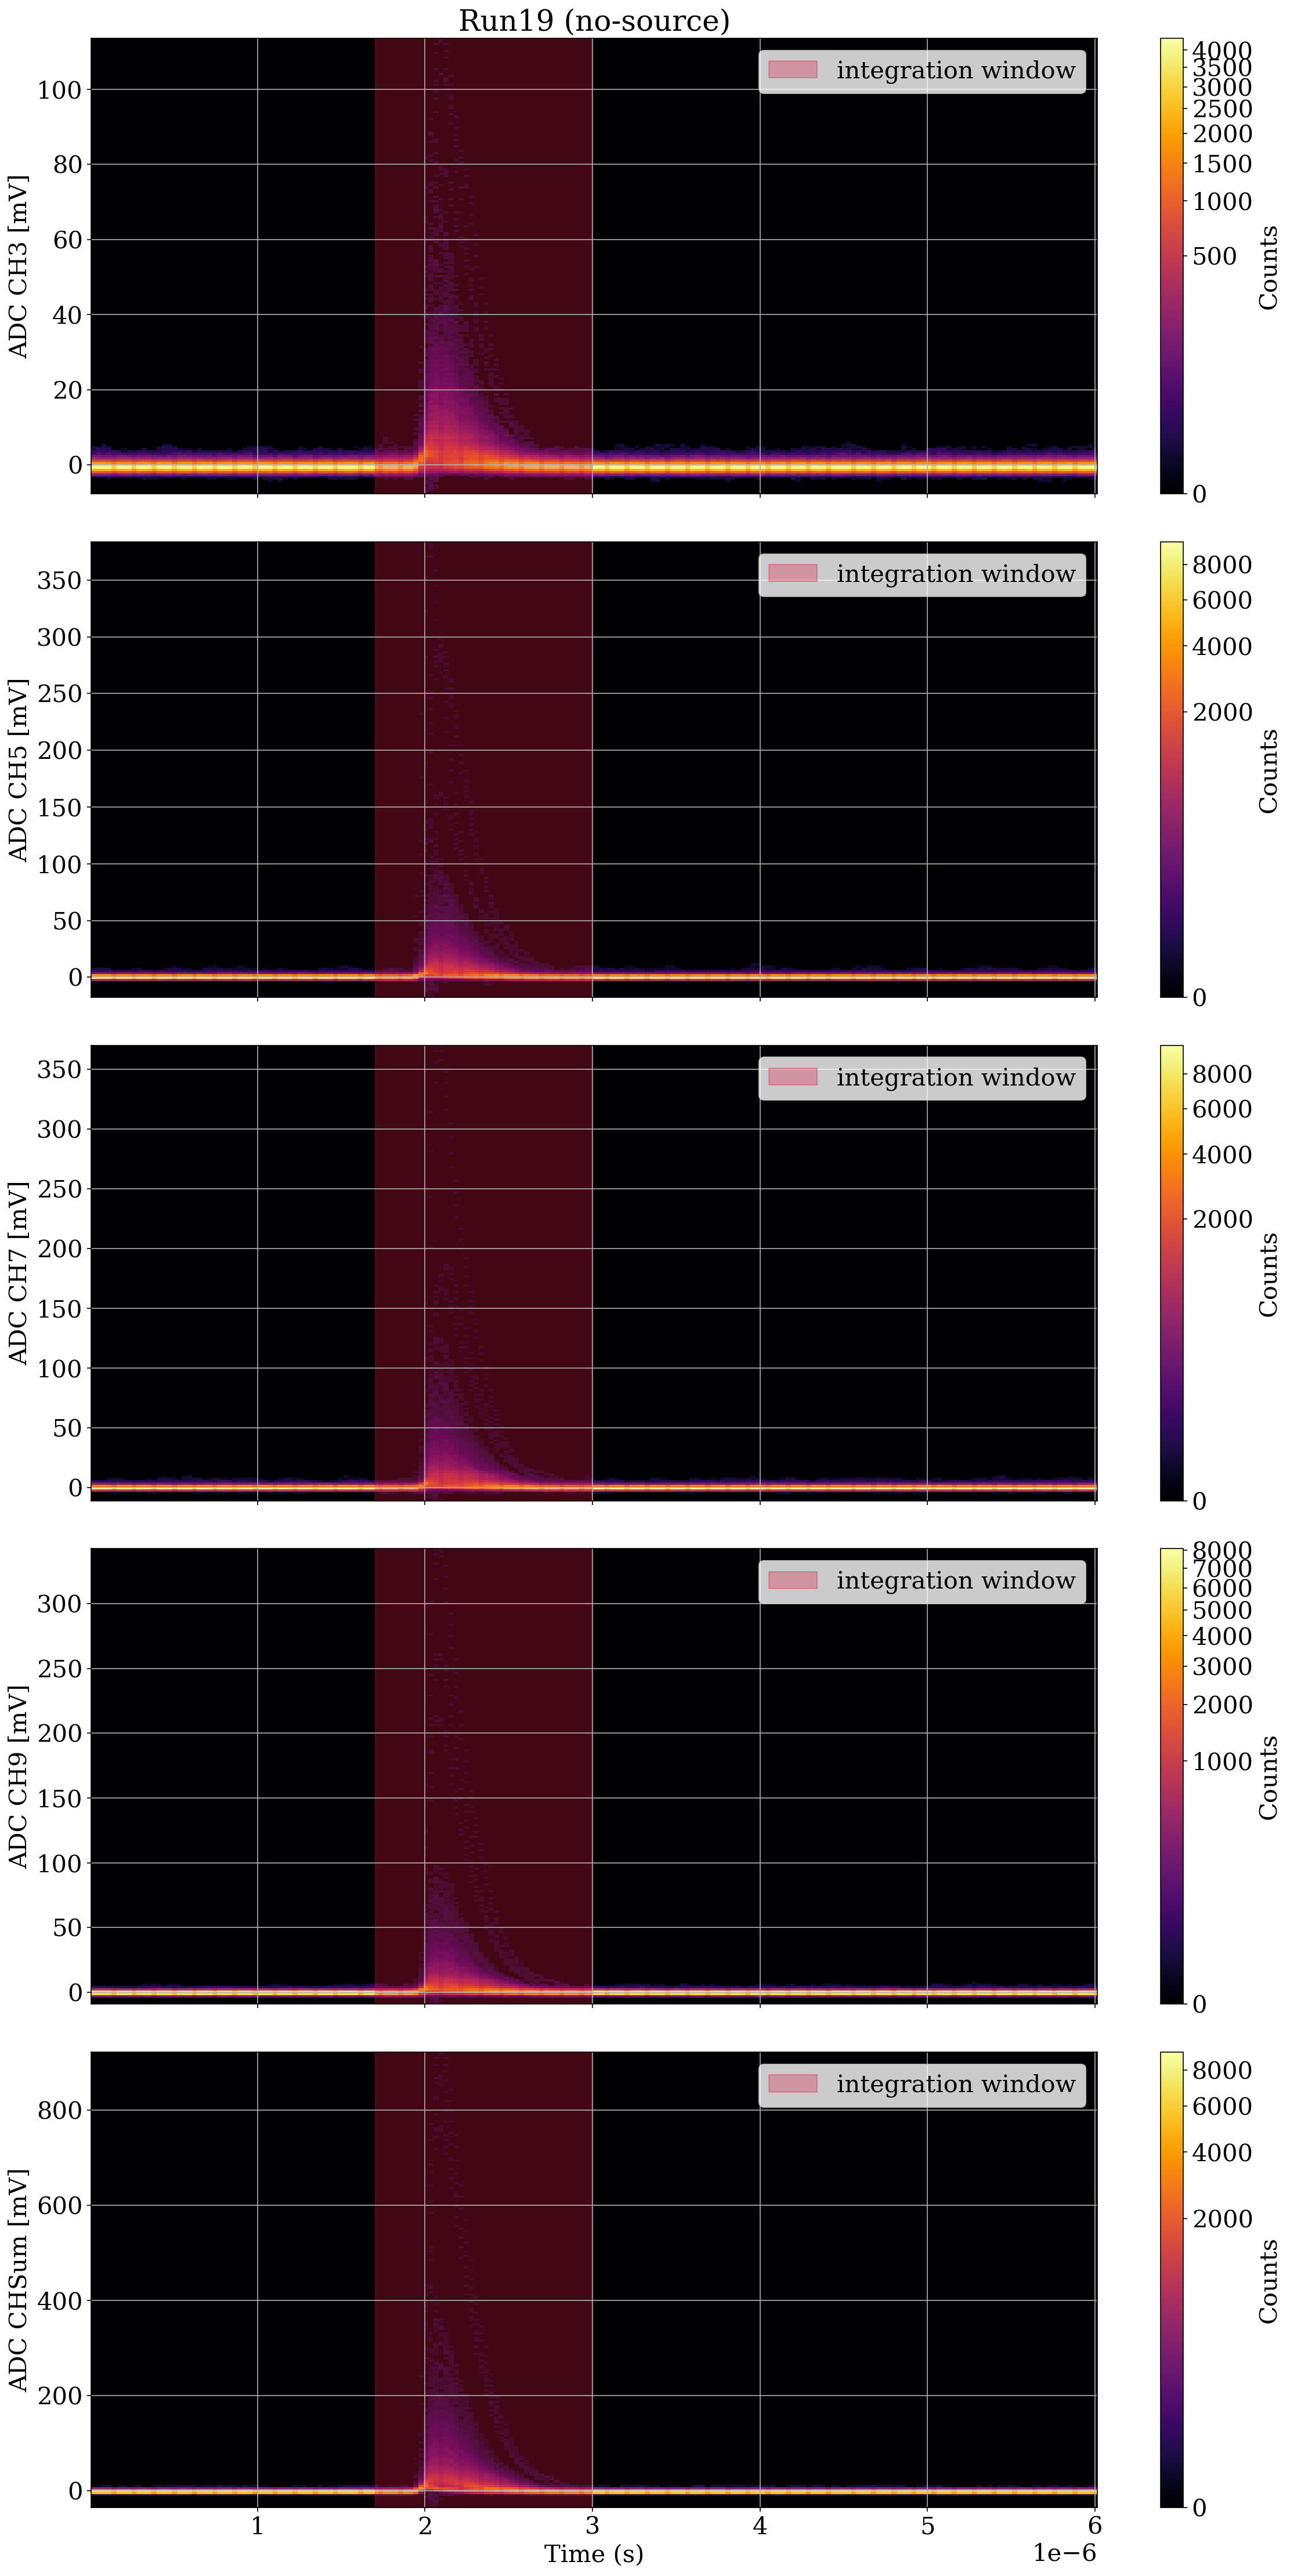

In [40]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f"{data_nosource['run']} ({data_nosource['source']})")
else:
    ax.set_title(f"{data_nosource['run']} ({data_nosource['source']})")


# Plot CHs
for i in range(len(channels)):

    if len(channels) > 1:
        ax = axs[i]

    voltage  = final_df_nosource[f'{channels[i]}'].values
    v_matrix = voltage.reshape(nevents_nosource, -1)
    # v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)
    v_matrix_corrected = v_matrix
    
    # voltage_matrix = np.array([...]) # shape (nevents, nsamples)
    hb = ax.hist2d(t_matrix_nosource.flatten(), v_matrix_corrected.flatten(), bins=[200, 200], 
                   cmap='inferno', norm=mcolors.PowerNorm(gamma=0.3))

    fig.colorbar(hb[3], ax=ax, label="Counts")

    ax.fill_between(time_nosource[time_window_nosource], v_matrix_corrected.min(), v_matrix_corrected.max(), 
                    color = colors[1], alpha = 0.3, label = 'integration window')

    ax.set_ylabel(f'ADC {channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

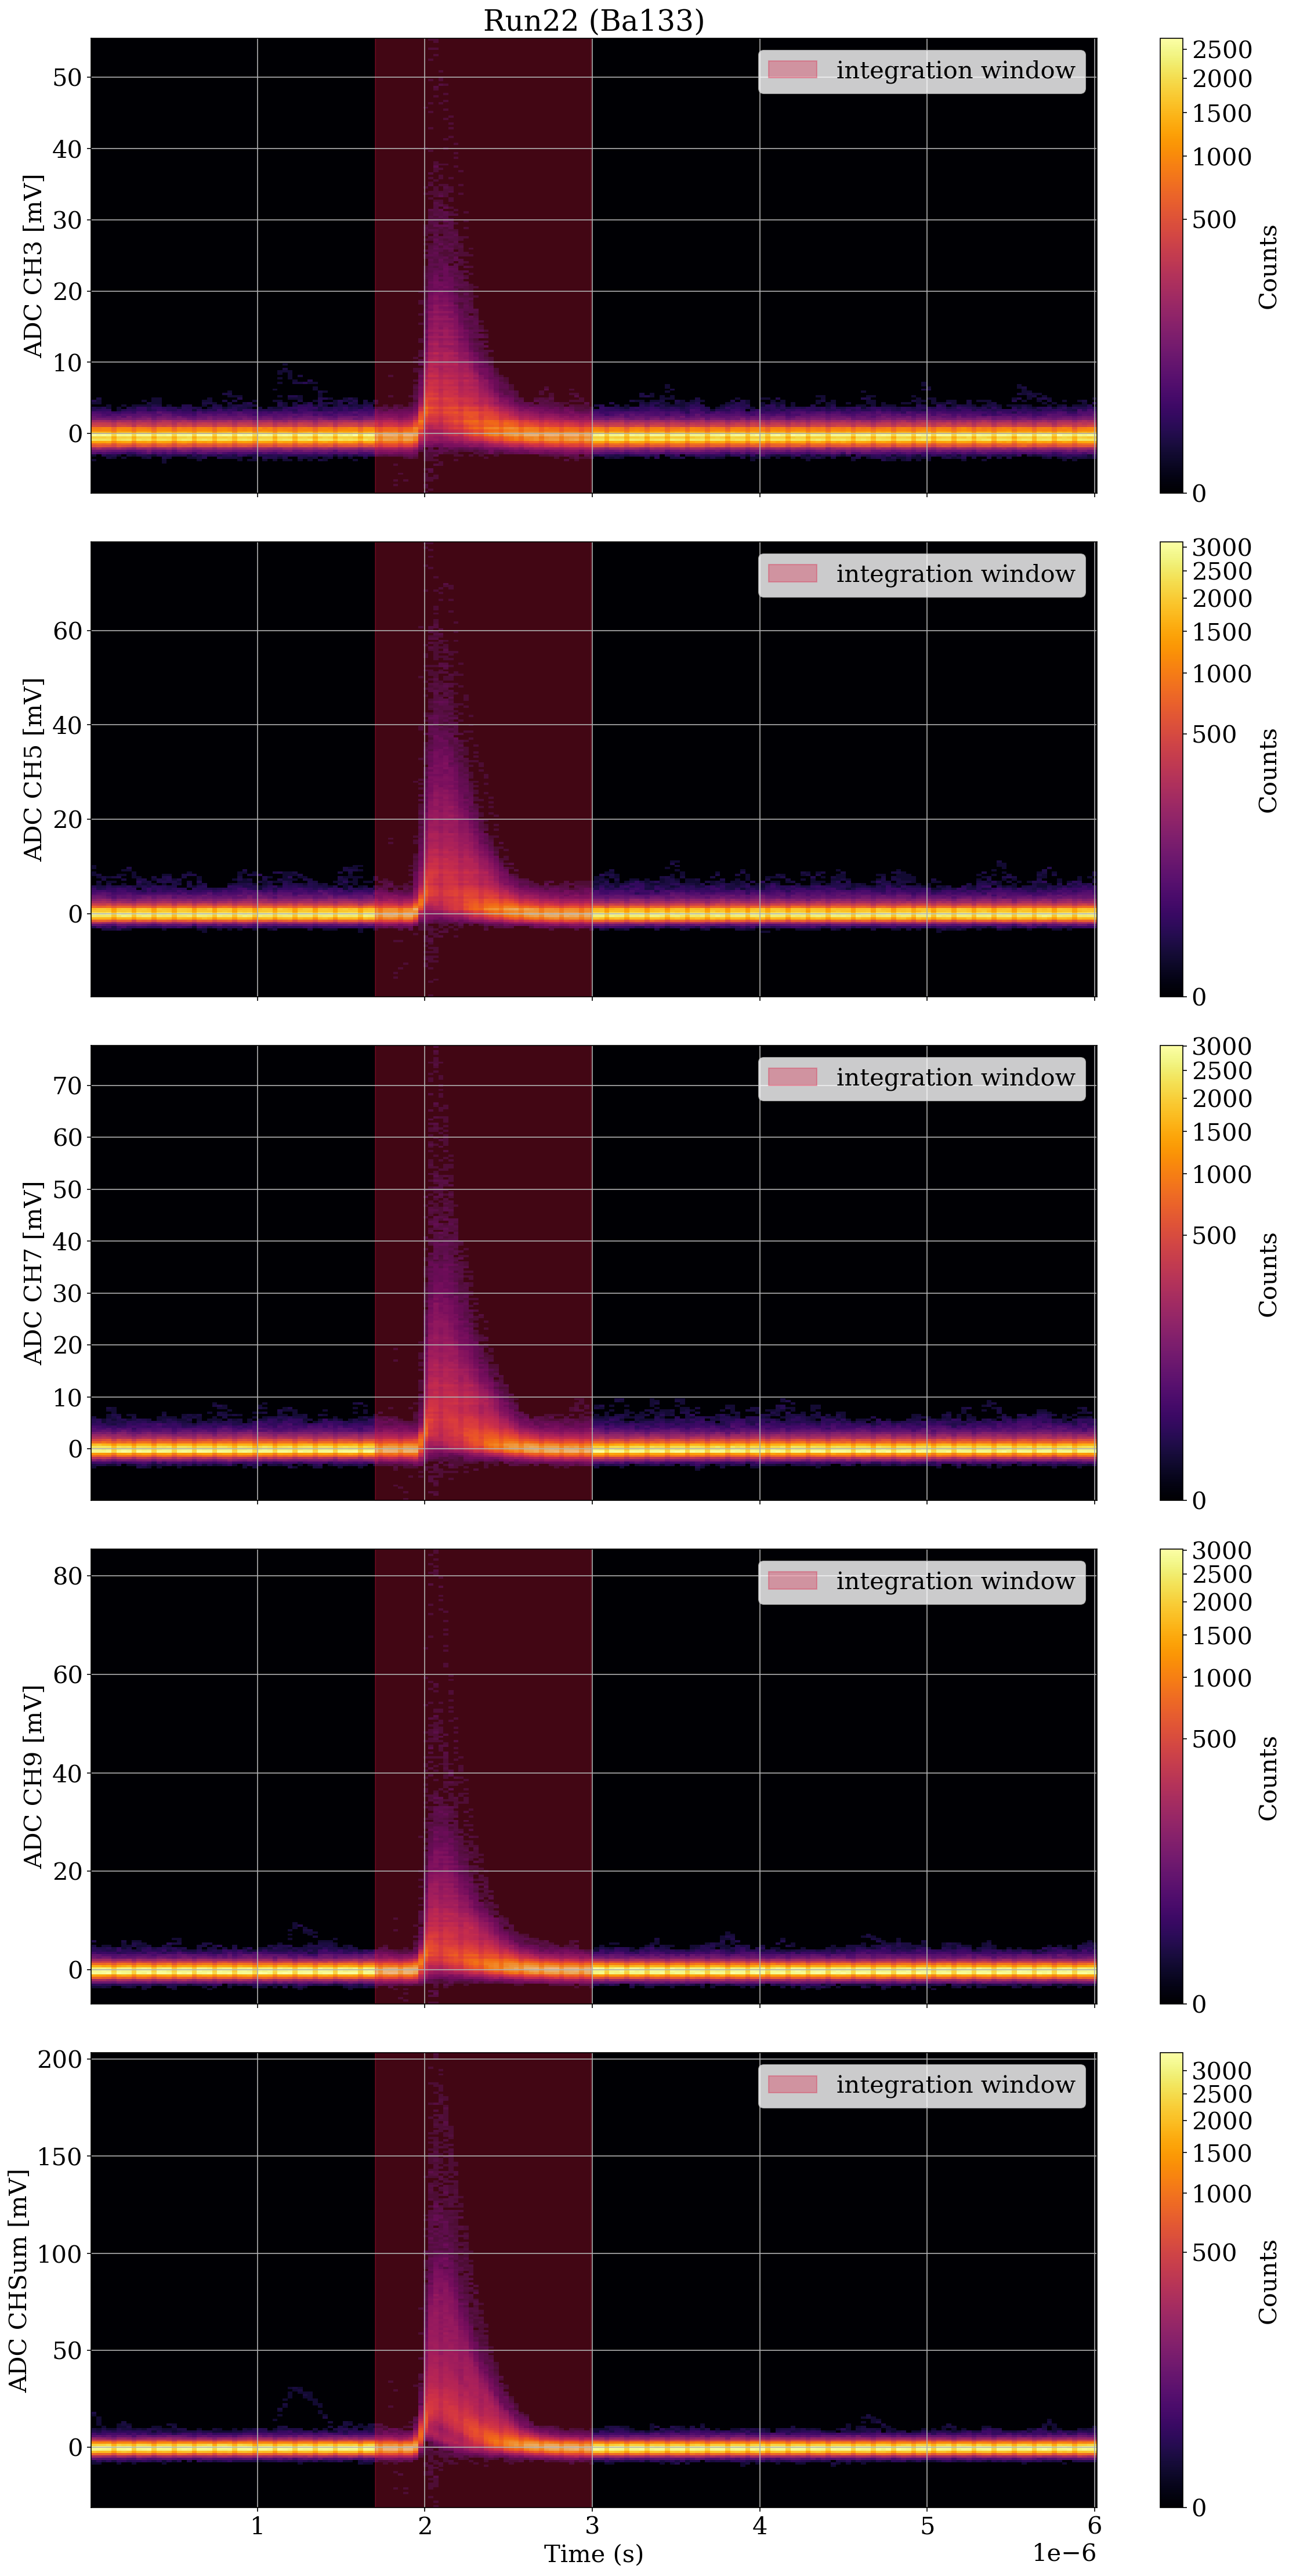

In [41]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f"{data_source['run']} ({data_source['source']})")
else:
    ax.set_title(f"{data_source['run']} ({data_source['source']})")


# Plot CHs
for i in range(len(channels)):

    if len(channels) > 1:
        ax = axs[i]

    voltage  = final_df_source[f'{channels[i]}'].values
    v_matrix = voltage.reshape(nevents_source, -1)
    # v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)
    v_matrix_corrected = v_matrix
    
    # voltage_matrix = np.array([...]) # shape (nevents, nsamples)
    hb = ax.hist2d(t_matrix_source.flatten(), v_matrix_corrected.flatten(), bins=[200, 200], 
                   cmap='inferno', norm=mcolors.PowerNorm(gamma=0.3))

    fig.colorbar(hb[3], ax=ax, label="Counts")

    ax.fill_between(time_source[time_window_source], v_matrix_corrected.min(), v_matrix_corrected.max(), 
                    color = colors[1], alpha = 0.3, label = 'integration window')

    ax.set_ylabel(f'ADC {channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

Run19 is 38.65 mins long
Run22 is 8.85 mins long


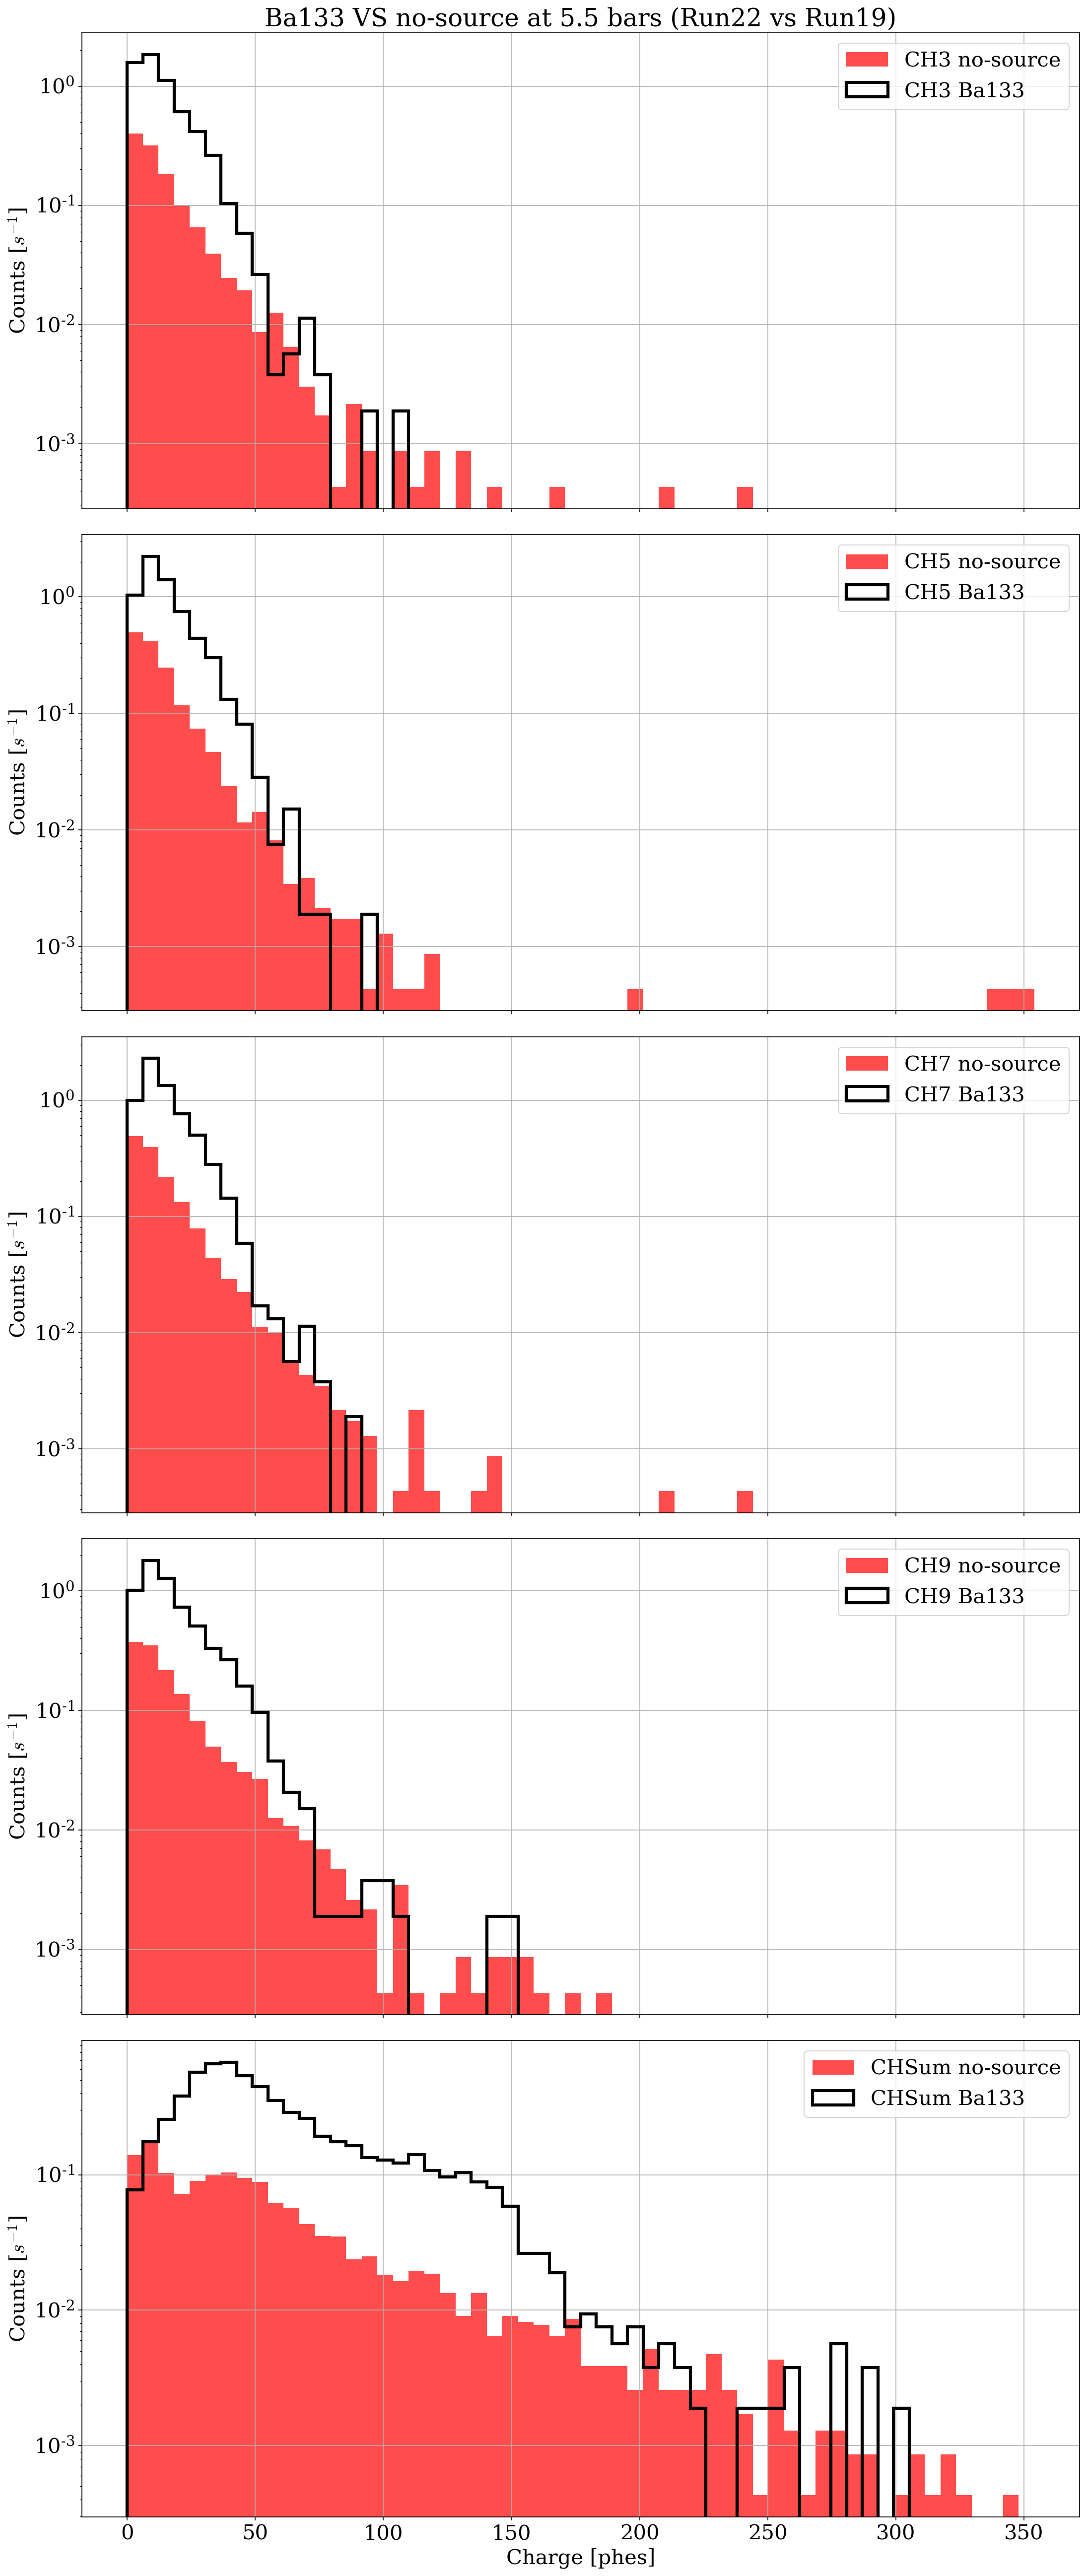

In [50]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(15, len(channels)*7), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(15, 7), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f"{data_source['source']} VS {data_nosource['source']} at {pressure} bars ({data_source['run']} vs {data_nosource['run']})")
else:
    ax.set_title(f"{data_source['source']} VS {data_nosource['source']} at {pressure} bars ({data_source['run']} vs {data_nosource['run']})")

charge_nosource_Sum = 0
charge_source_Sum   = 0

run_duration_nosource   = ((final_df_nosource.groupby('file_idx').max().event_time - final_df_nosource.groupby('file_idx').min().event_time)*8e-9).sum()
print(f"{data_nosource['run']} is {run_duration_nosource/60:.2f} mins long")
run_duration_source     = ((final_df_source.groupby('file_idx').max().event_time - final_df_source.groupby('file_idx').min().event_time)*8e-9).sum()
print(f"{data_source['run']} is {run_duration_source/60:.2f} mins long")


# Plot CHs
for i, ch in enumerate(channels):

    if len(channels) > 1:
        ax = axs[i]
    
    # NO SOURCE -------------------------------------------------------------------------
    voltage_nosource = final_df_nosource[f'{channels[i]}'].values

    v_matrix_nosource                    = voltage_nosource.reshape(nevents_nosource, -1)
    # v_matrix_corrected_nosource, _, _    = cig.BaselineCorrection(v_matrix_nosource, window=window_width)
    v_matrix_corrected_nosource = v_matrix_nosource

    charge_nosource = np.trapz(v_matrix_corrected_nosource[:, time_window_nosource]*1e-3,
                      x = time_nosource[time_window_nosource]
                      ,axis = 1)
    
    if data_nosource['pes']:
        if ch != 'CHSum':
            charge_nosource = cig.ChargeToPes(charge_nosource, channel=i+1, 
                                        temp = data_nosource['temperature'], amplified = data_nosource['is_amplified'], CHAmp=data_nosource['amp_factors'])
            charge_nosource_Sum = charge_nosource_Sum + charge_nosource
        else:
            charge_nosource = charge_nosource_Sum
    else:
        charge_nosource_Sum = charge_nosource


    events_nosource, bins, image = ax.hist(charge_nosource
                                ,bins = int(np.sqrt(len(charge_nosource))) 
                                ,weights=np.ones_like(charge_nosource)/run_duration_nosource
                                ,range = (0, 354)
                                # ,range = (-1e-9, 1.5e-7/4)
                                ,density = False
                                ,histtype   ='stepfilled'
                                ,color      = 'r'
                                ,ls         = '-'
                                ,lw         = 3
                                ,alpha      = 0.7
                                ,label = f"{ch} {data_nosource['source']}"
                                )
    
    # SOURCE -------------------------------------------------------------------------
    voltage_source = final_df_source[f'{channels[i]}'].values

    v_matrix_source                    = voltage_source.reshape(nevents_source, -1)
    # v_matrix_corrected_source, _, _    = cig.BaselineCorrection(v_matrix_source, window=window_width)
    v_matrix_corrected_source = v_matrix_source

    charge_source = np.trapz(v_matrix_corrected_source[:, time_window_source]*1e-3,
                      x = time_source[time_window_source]
                      ,axis = 1)

    if data_source['pes']:
        if ch != 'CHSum':
            charge_source = cig.ChargeToPes(charge_source, channel=i+1, 
                                        temp = data_source['temperature'], amplified = data_source['is_amplified'], CHAmp=data_source['amp_factors'])
            charge_source_Sum = charge_source_Sum + charge_source
        else:
            charge_source = charge_source_Sum
    else:
        charge_source_Sum = charge_source

    events_source, bins, image = ax.hist(charge_source
                                ,bins = bins
                                ,weights=np.ones_like(charge_source)/run_duration_source
                                ,density = False
                                ,histtype   ='step'
                                ,color      = 'k'
                                ,ls         = '-'
                                ,lw         = 3
                                ,alpha      = 1
                                ,label = f"{ch} {data_source['source']}"
                                )
    
    ax.set_ylabel(fr'Counts [$s^{{-1}}$]')
    ax.grid(True)
    ax.set_yscale('log')
    ax.legend()

if len(channels) > 1:
    if pes:
        axs[-1].set_xlabel(r'Charge [phes]')
    else:
        axs[-1].set_xlabel(r'Charge [V $\cdot$ s]')
else:
    ax.set_xlabel(r'Charge [V $\cdot$ s]')

# plt.xlim(0.5, 550)

# Improve layout
plt.tight_layout()
plt.show()

In [51]:
charge_nosource_Sum

array([ 50.62532485, 171.18413967,  34.92125086, ...,  27.79193362,
         6.52827544,  -4.27669381])

In [52]:
bins

array([  0.        ,   6.10344828,  12.20689655,  18.31034483,
        24.4137931 ,  30.51724138,  36.62068966,  42.72413793,
        48.82758621,  54.93103448,  61.03448276,  67.13793103,
        73.24137931,  79.34482759,  85.44827586,  91.55172414,
        97.65517241, 103.75862069, 109.86206897, 115.96551724,
       122.06896552, 128.17241379, 134.27586207, 140.37931034,
       146.48275862, 152.5862069 , 158.68965517, 164.79310345,
       170.89655172, 177.        , 183.10344828, 189.20689655,
       195.31034483, 201.4137931 , 207.51724138, 213.62068966,
       219.72413793, 225.82758621, 231.93103448, 238.03448276,
       244.13793103, 250.24137931, 256.34482759, 262.44827586,
       268.55172414, 274.65517241, 280.75862069, 286.86206897,
       292.96551724, 299.06896552, 305.17241379, 311.27586207,
       317.37931034, 323.48275862, 329.5862069 , 335.68965517,
       341.79310345, 347.89655172, 354.        ])

In [53]:
events_source.sum(), events_nosource.sum()

(6.42222136810413, 1.455433566988103)

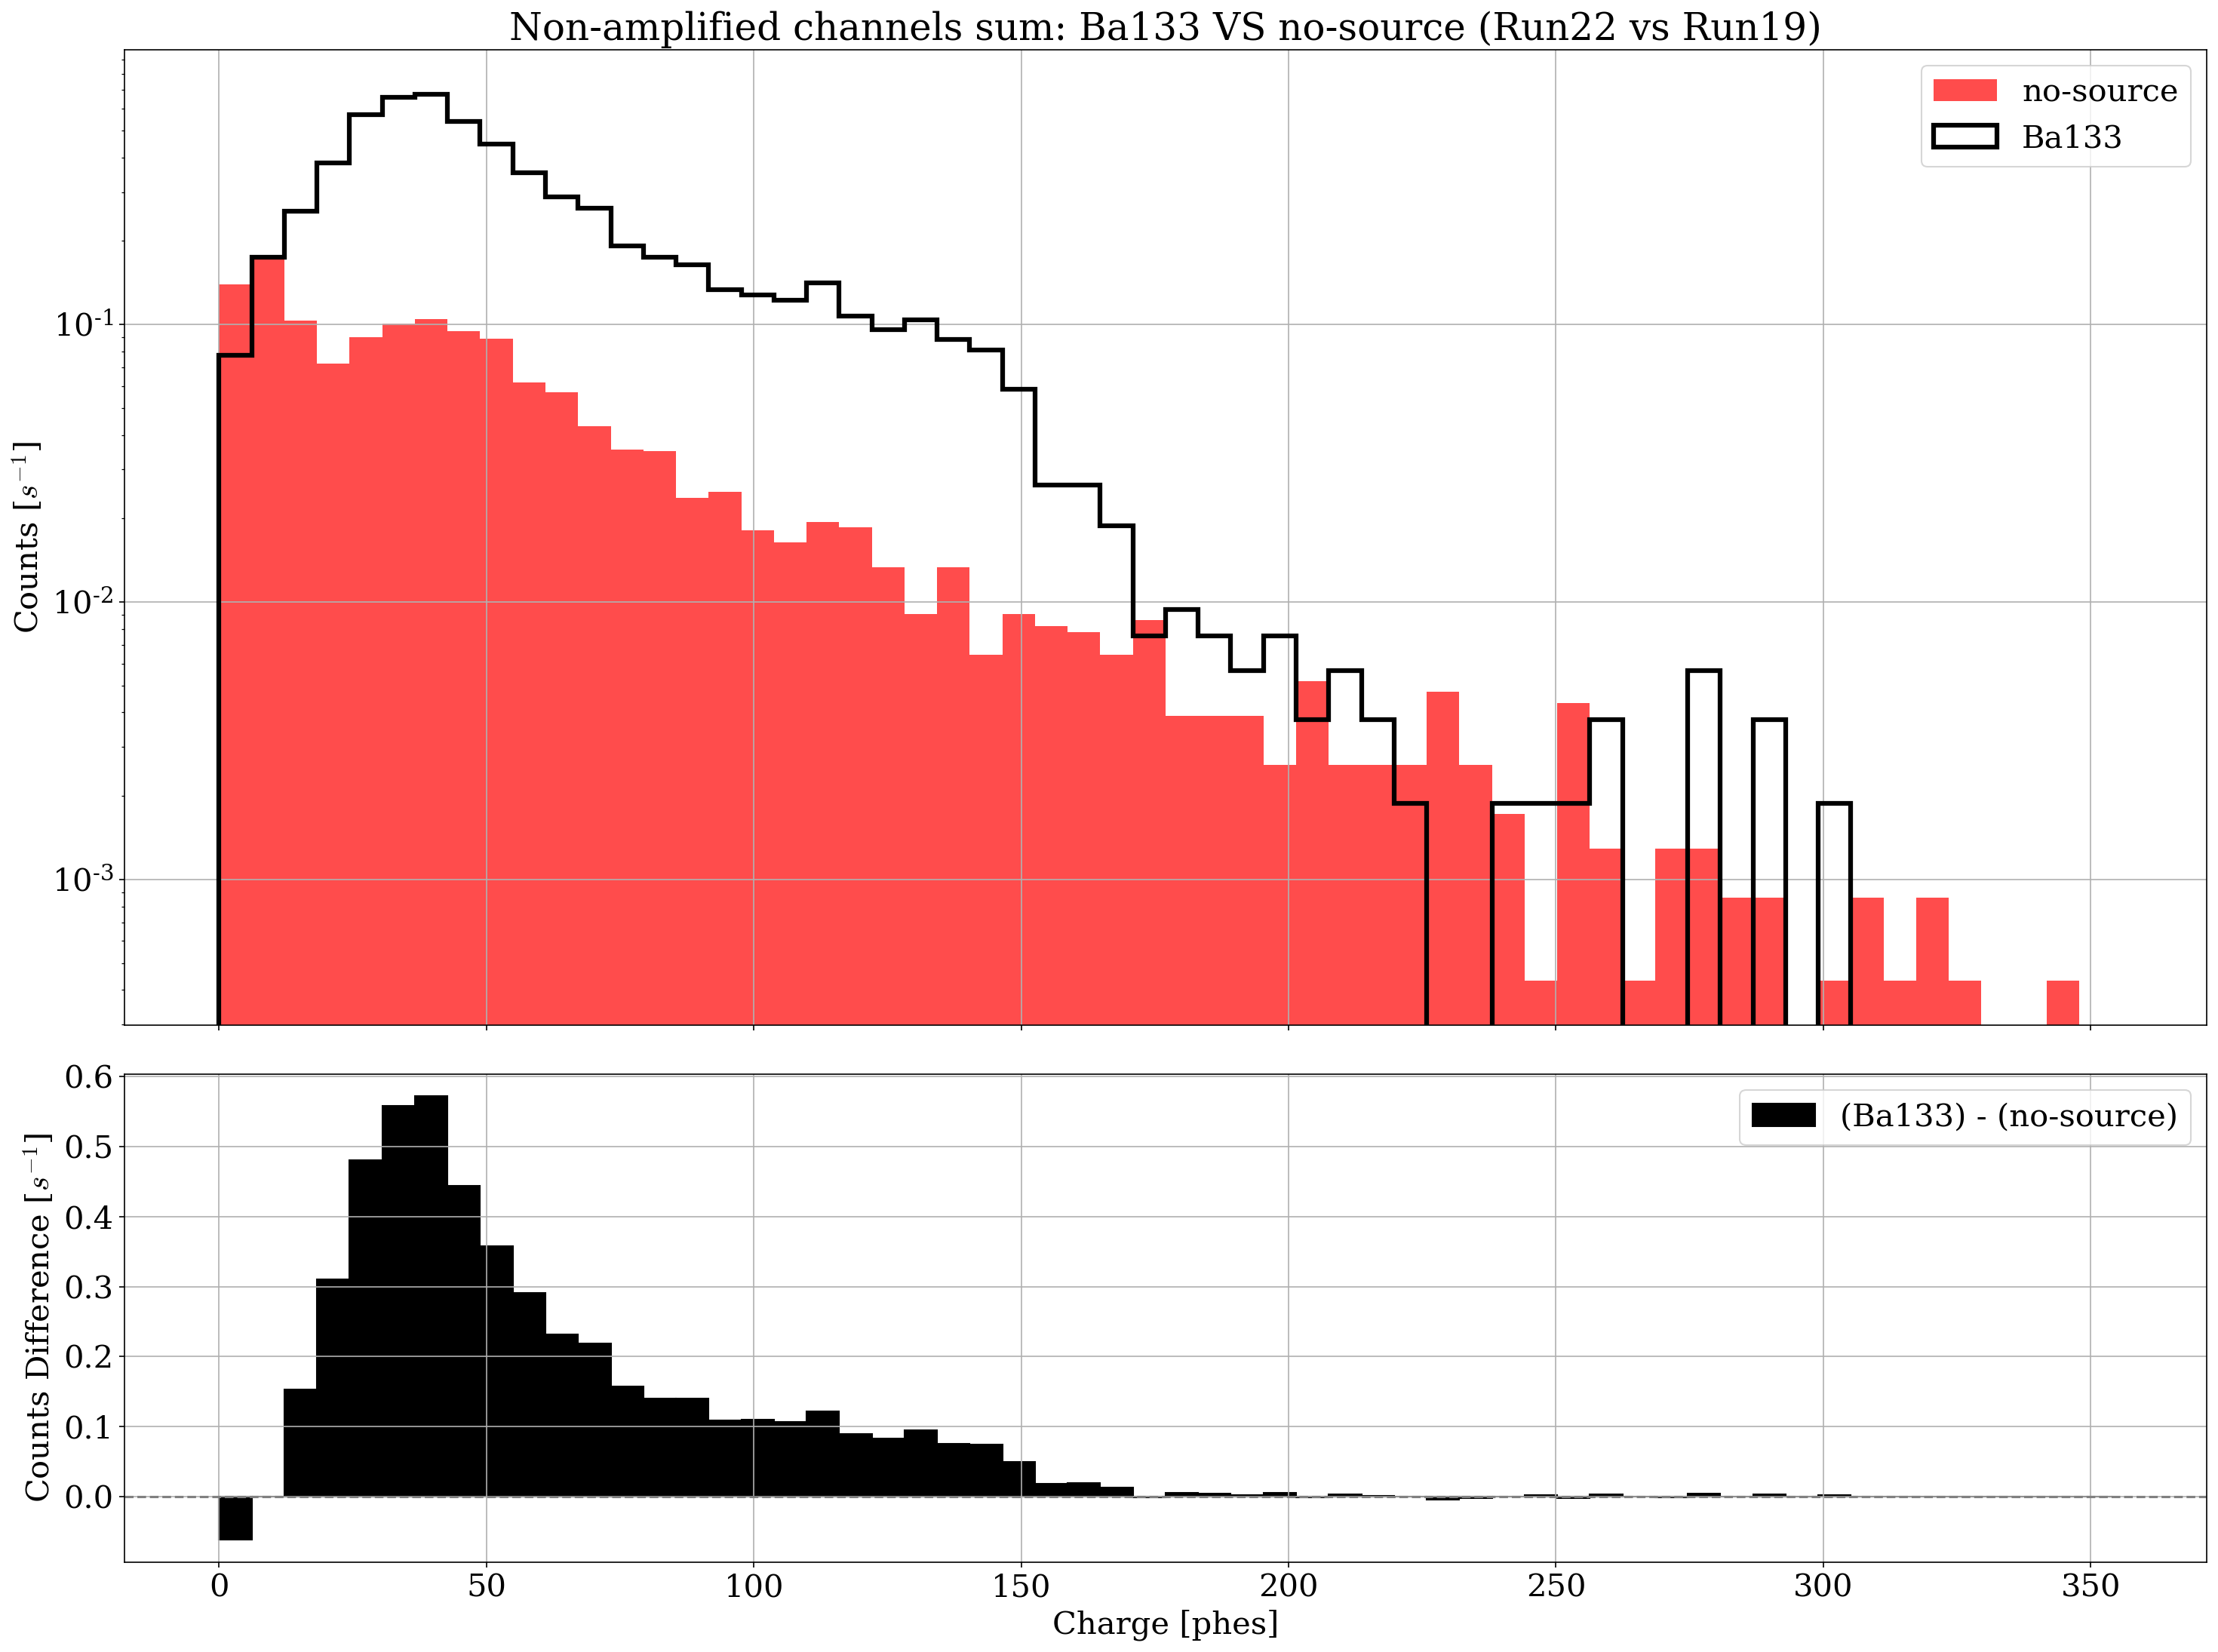

: 

In [ ]:
# Create GridSpec with two rows, one smaller
fig, axs = plt.subplots(2, 1,
                        figsize=(20, 15),
                        dpi=150,
                        sharex=True,
                        gridspec_kw={'height_ratios': [2, 1]}  # top subplot twice as tall
                        )

if amplified:
    axs[0].set_title(f"Amplified channels sum: {data_source['source']} VS {data_nosource['source']} ({data_source['run']} vs {data_nosource['run']})")
else:
    axs[0].set_title(f"Non-amplified channels sum: {data_source['source']} VS {data_nosource['source']} ({data_source['run']} vs {data_nosource['run']})")



# PLOT 1: Sum histograms
ax = axs[0]

events_nosource, bins, image = ax.hist(charge_nosource_Sum
                                        ,bins = bins
                                        ,weights=np.ones_like(charge_nosource_Sum)/run_duration_nosource
                                        ,density = False
                                        ,histtype   ='stepfilled'
                                        ,color      = 'r'
                                        ,ls         = '-'
                                        ,lw         = 3
                                        ,alpha      = 0.7
                                        ,label = f"{data_nosource['source']}"
                                        )


events_source, bins, image = ax.hist(charge_source_Sum
                                    ,bins = bins
                                    ,weights=np.ones_like(charge_source_Sum)/run_duration_source
                                    ,density = False
                                    ,histtype   ='step'
                                    ,color      = 'k'
                                    ,ls         = '-'
                                    ,lw         = 3
                                    ,alpha      = 1
                                    ,label = f"{data_source['source']}"
                                    )


ax.set_ylabel(fr'Counts [$s^{{-1}}$]')
ax.grid(True)
ax.set_yscale('log')
ax.legend()



# PLOT 2: Histograms difference
ax = axs[1]

bin_centers = (bins[1:] + bins[:-1])/2

events_difference = events_source - events_nosource

width = np.diff(bins)
ax.bar(bin_centers, events_difference, width=width, align='center',
       color='k', edgecolor='k', alpha=1, label=f"({data_source['source']}) - ({data_nosource['source']})")

ax.axhline(0, color='grey', linestyle='--')
ax.set_ylabel(fr'Counts Difference [$s^{{-1}}$]')
ax.set_yscale('linear')     # linear to show negatives
ax.grid(True)
ax.legend()

if pes:
    axs[-1].set_xlabel(r'Charge [phes]')
else:
    axs[-1].set_xlabel(r'Charge [V $\cdot$ s]')


# Improve layout
plt.tight_layout()
plt.show()